In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os, fnmatch, glob
from glob import glob 
from sklearn.model_selection import train_test_split
%matplotlib inline
from PIL import Image
import torchvision.transforms as tfs
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import scipy
import scipy.io
import cv2
#import scipy.io as io

In [ ]:
class shangTechTrans:
  def __init__(self):
    pass
  def imgTransformer(self, dataimg, label, scaleFactor):
    #https://github.com/CommissarMa/MCNN-pytorch/blob/master/my_dataloader.py
    rowScale, colScale = int(np.shape(dataimg)[0]//scaleFactor), int(np.shape(dataimg)[1]//scaleFactor)
    # trans = tfs.Compose([
    #       tfs.ToTensor(),
    #       tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #   ])
    trans = tfs.Compose([
           tfs.ToTensor()])
    dataimg = trans(dataimg)
    label  = cv2.resize(label,(colScale,rowScale))
    return dataimg, label
  def shTrans(self, data, labelIm, scaleFactor):
    imgTrans, labelIm = self.imgTransformer(data, labelIm, scaleFactor)
    labelIm = labelIm*(scaleFactor**2)
    #imgTrans = torch.from_numpy(imgTrans).long()
    labelIm = torch.from_numpy(labelIm)
    return imgTrans, labelIm

In [ ]:
class shangTechDataset(Dataset):
  def __init__(self, transformer, dataDirs, labelDirs):
    self.trans = transformer
    self.data_list = dataDirs
    self.label_list = labelDirs
  def __getitem__(self, idx):
    label = np.load(self.label_list[idx])
    img = np.load(self.data_list[idx])
    img, label = self.trans.shTrans(data = img, labelIm = label, scaleFactor = 4)
    return  img, label
  def __len__(self):
    return len(self.data_list)

**Train Data**

In [ ]:
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GT_PatchesNew/*.npy'
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/IMG_PatchesNew/*.npy'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
trainDataDir, valtDataDir, trainLabelDir, valLabelDir = train_test_split(dataDir, labelDir, test_size=0.1, random_state=1)

In [ ]:
shangTransform = shangTechTrans()
BATCHSIZE = 1
trainData = shangTechDataset(transformer = shangTransform, dataDirs = trainDataDir, labelDirs = trainLabelDir)
trainDataSHT = DataLoader(trainData, batch_size=BATCHSIZE, shuffle=True)

In [ ]:
shangTransform = shangTechTrans()
valData = shangTechDataset(transformer = shangTransform, dataDirs = valtDataDir, labelDirs = valLabelDir)
valDataSHT = DataLoader(valData, batch_size=BATCHSIZE, shuffle=True)

**Test Data**

In [ ]:
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/GT_PatchesNew/*.npy'
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/IMG_PatchesNew/*.npy'
dataDirTest = sorted(glob(dataBaseAddr))
labelDirTest = sorted(glob(labelBaseAddr))

In [ ]:
np.shape(dataDirTest), np.shape(labelDirTest)

((3755,), (3756,))

In [ ]:
trestData = shangTechDataset(transformer = shangTransform, dataDirs = dataDirTest, labelDirs = labelDirTest)
testDataSHT = DataLoader(trestData, batch_size=BATCHSIZE, shuffle=True)

tensor(12.0632, dtype=torch.float64)


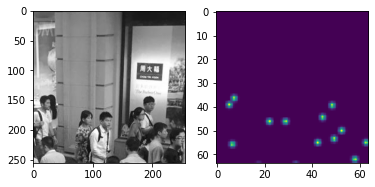

In [ ]:
i = 0
for img,gt_dmap in trainDataSHT:
  #imgNew = img.view(-1,256,256).shape
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img.view(-1,256,256)[0], cmap = 'gray')
  plt.subplot(1,2,2)
  plt.imshow(gt_dmap[0])
  print(torch.sum(gt_dmap[0]))
  break
  #plt.figure()
  #plt.plot(gt_dmap)

In [ ]:
class CCNN(nn.Module):
    def __init__(self):
      super(CCNN, self).__init__()
      PAD = 3
      DIL = 1
      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(11,11), padding = 5, stride = 1), nn.ReLU())
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(7,7), padding = 3, stride = 1)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding = 2, stride = 1)
      self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=1000, kernel_size=(1,1), padding = 0, stride = 1), nn.ReLU())
      self.conv5 = nn.Sequential(nn.Conv2d(in_channels=1000, out_channels=400, kernel_size=(1,1), padding = 0, stride = 1), nn.ReLU())
      self.conv6 = nn.Sequential(nn.Conv2d(in_channels=400, out_channels=1, kernel_size=(1,1), padding = 0, stride = 1))
      #self._initialize_weights()
    def forward(self, x):
      x1 = self.conv1(x)
      x2 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2))
      x3 = F.relu(F.max_pool2d(self.conv3(x2), kernel_size=2, stride=2))
      x4 = self.conv4(x3)
      x5 = self.conv5(x4)
      xOut = self.conv6(x5)
      return xOut
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
def plotLoss(epoch, trainLoss, testLoss):
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy Loss')
  plt.title('Loss')
  plt.plot(epoch, trainLoss, label='Train')
  plt.plot(epoch, testLoss, label='Test')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
def showResult(dataLoader, net, epoch_):
  totalLoss = 0; i = 0
  net.eval()
  with torch.no_grad():
    for img,  gt_dmap in dataLoader:
      if torch.cuda.is_available:
        img = img.cuda()
        gt_dmap =  gt_dmap.cuda()
      outputs = net(img.float())
      fig, axs = plt.subplots(1, 3, figsize=(15,5))
      fig.suptitle('Epoch %d'%epoch_)
      axs[0].imshow(img.view(-1,256,256)[0].cpu().numpy(), cmap = 'gray')
      axs[0].set_title('Original Image')
      axs[1].imshow(gt_dmap.view(-1,64,64)[0].cpu().numpy())
      axs[1].set_title('True Label')
      axs[2].imshow(outputs.view(-1,64,64)[0].cpu().numpy())
      axs[2].set_title('Predicted Output')
      plt.show()
      print("True Number: ", torch.sum(gt_dmap.view(-1,64,64)[0]),
            "Predicted Number: ", torch.sum(outputs.view(-1,64,64)[0]))
      if i%5 == 4:
        break
      i +=1


In [ ]:
def calcLoss(dataloader, net, criterion):
  totalLoss = 0; i = 0
  net.eval()
  with torch.no_grad():
    for img,  gt_dmap in dataloader:
      if torch.cuda.is_available:
        img = img.cuda()
        gt_dmap =  gt_dmap.cuda()
      i +=1
      outputs = net(img.float())
      loss = criterion(outputs.view(-1,64,64), gt_dmap.view(-1,64,64).float())
      totalLoss += loss.item()
  avgLoss = totalLoss/i
  return avgLoss

In [ ]:
net = CCNN()
lossTrainHist = []; lossValHist = []; epochHist = []
if torch.cuda.is_available():
    net = net.cuda()
#criterion = nn.L1Loss()
#optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.005)
device=torch.device("cuda")
criterion=nn.MSELoss().to(device)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-7,
#                                 momentum=0.95, )
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
# lr = 0.00001
# optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.005)

**********Epoch: 1 **********
 Epoch 1,  Iteration     1,  Loss: 0.4160545766
Sum Label:  tensor(0., device='cuda:0', dtype=torch.float64) Sum Prediction:  tensor(1865.4703, device='cuda:0', grad_fn=<SumBackward0>)


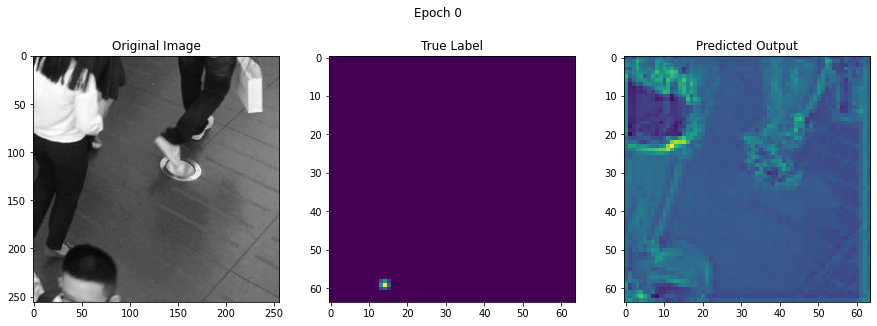

True Number:  tensor(0.9866, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(18.1828, device='cuda:0')


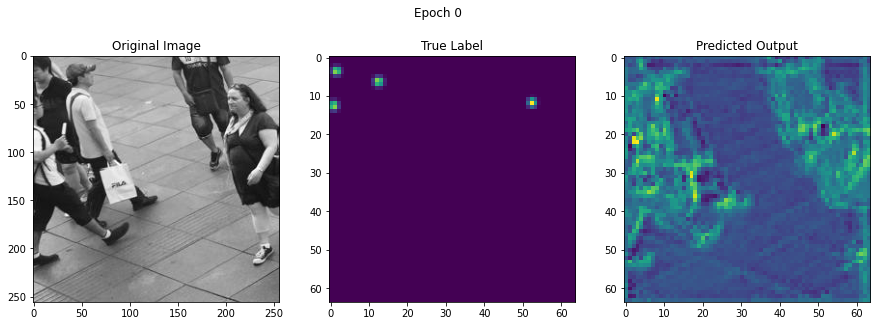

True Number:  tensor(3.9726, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(18.0629, device='cuda:0')


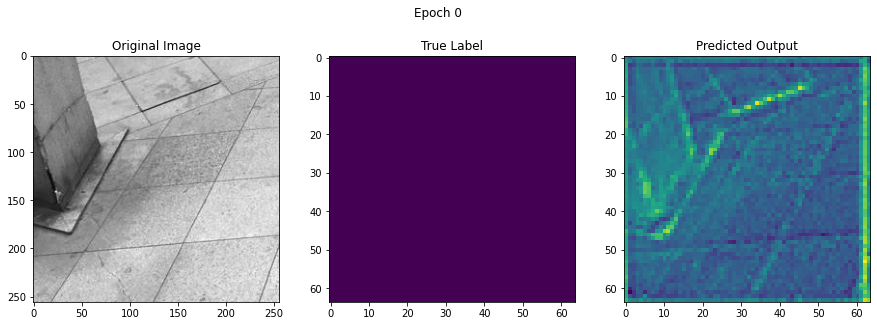

True Number:  tensor(0., device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(-107.5769, device='cuda:0')


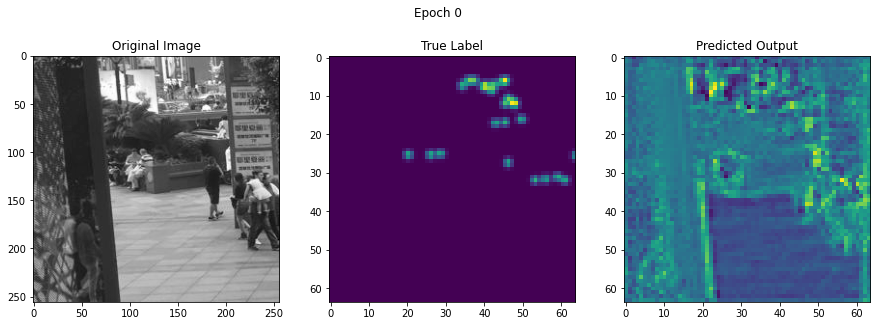

True Number:  tensor(24.4761, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(36.7959, device='cuda:0')


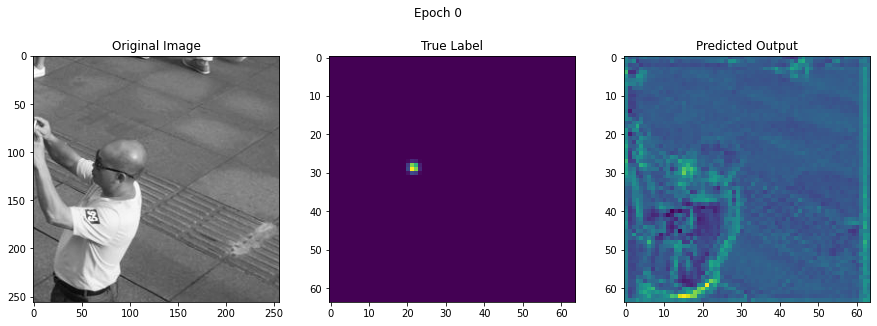

True Number:  tensor(1.0135, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(-38.5406, device='cuda:0')


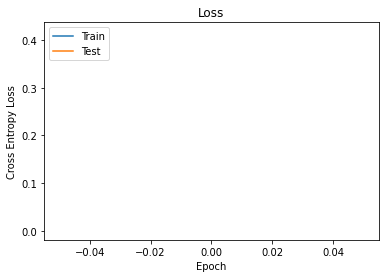

 Epoch 1,  Iteration  1001,  Loss: 0.0009906151
Sum Label:  tensor(34.2915, device='cuda:0', dtype=torch.float64) Sum Prediction:  tensor(18.9509, device='cuda:0', grad_fn=<SumBackward0>)


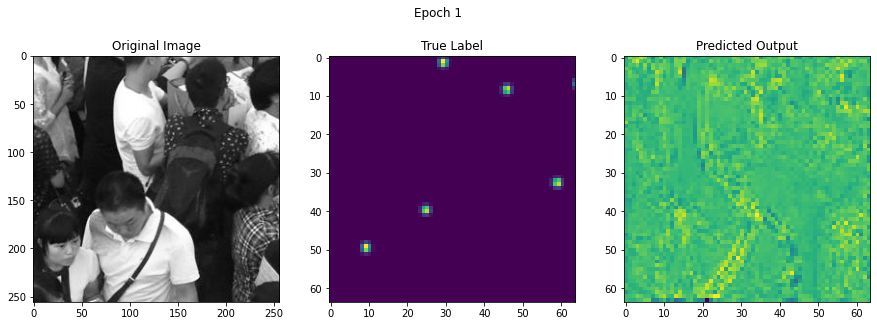

True Number:  tensor(5.2170, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(18.0865, device='cuda:0')


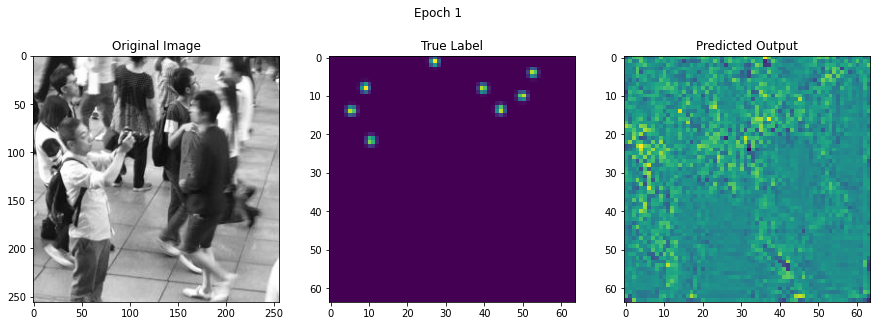

True Number:  tensor(7.9865, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(20.2516, device='cuda:0')


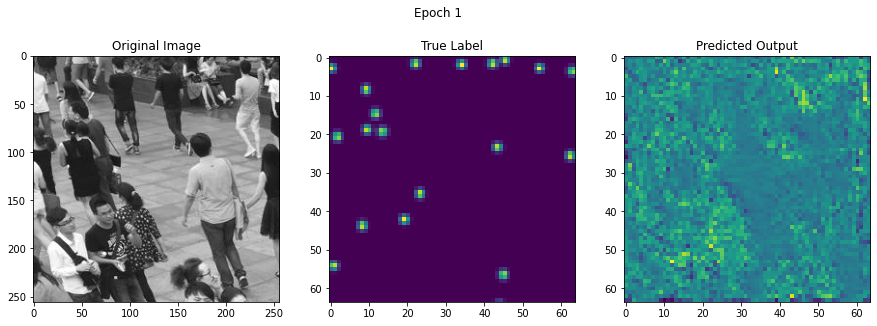

True Number:  tensor(18.7115, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(23.2965, device='cuda:0')


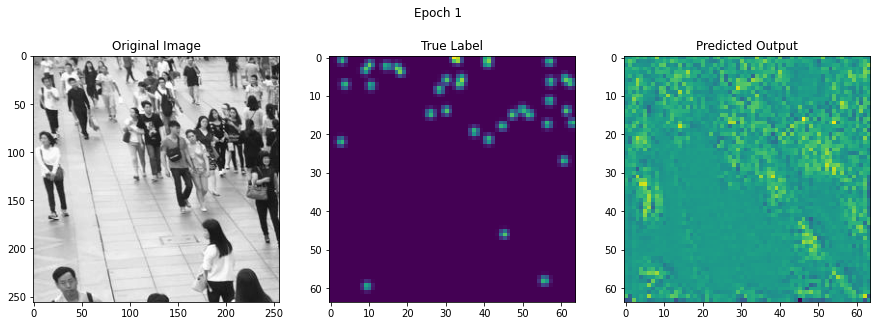

True Number:  tensor(36.4025, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(25.7119, device='cuda:0')


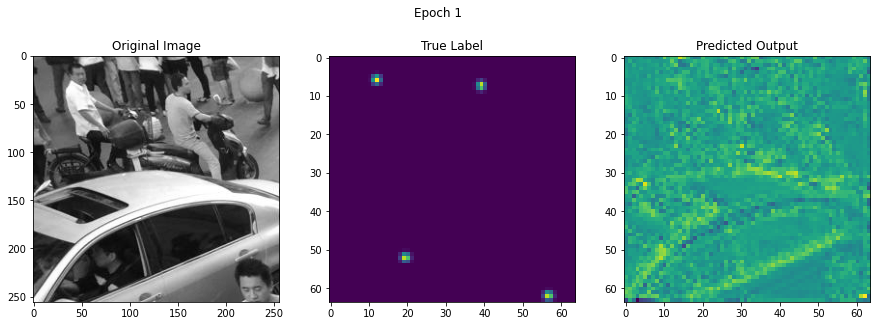

True Number:  tensor(3.9865, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(23.5618, device='cuda:0')


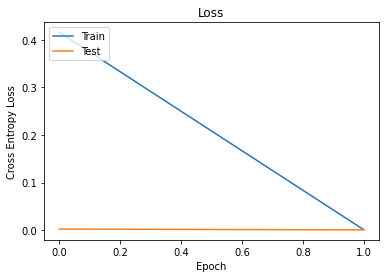

 Epoch 1,  Iteration  2001,  Loss: 0.0007000024
Sum Label:  tensor(3.9731, device='cuda:0', dtype=torch.float64) Sum Prediction:  tensor(9.6260, device='cuda:0', grad_fn=<SumBackward0>)


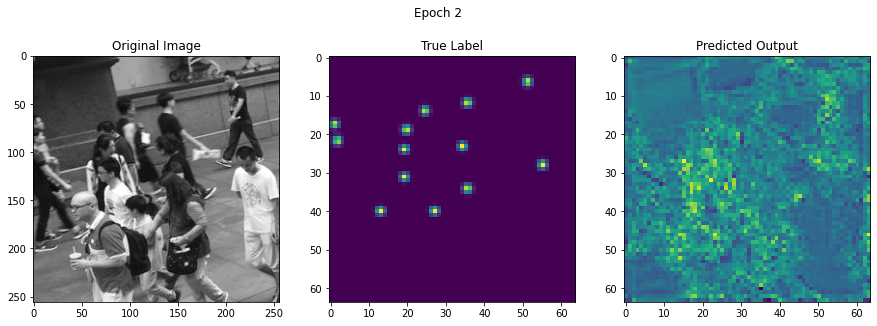

True Number:  tensor(12.9150, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(14.7869, device='cuda:0')


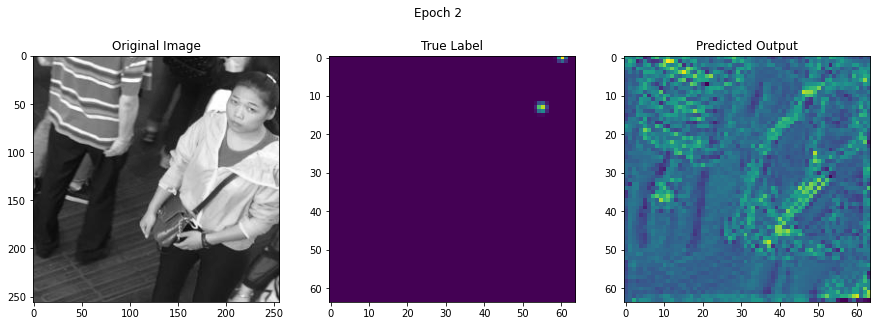

True Number:  tensor(1.6969, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(11.8479, device='cuda:0')


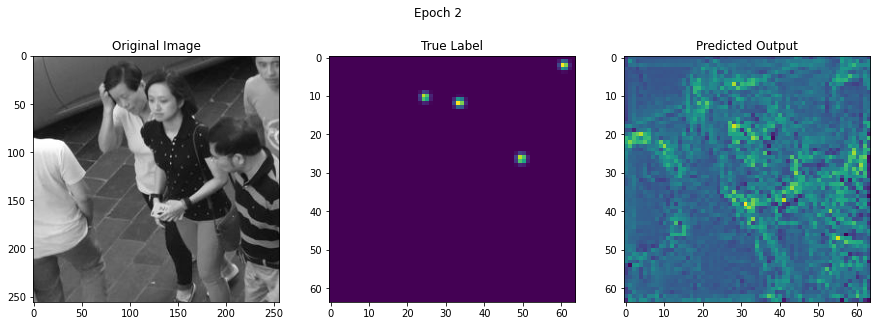

True Number:  tensor(4.0269, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(9.9400, device='cuda:0')


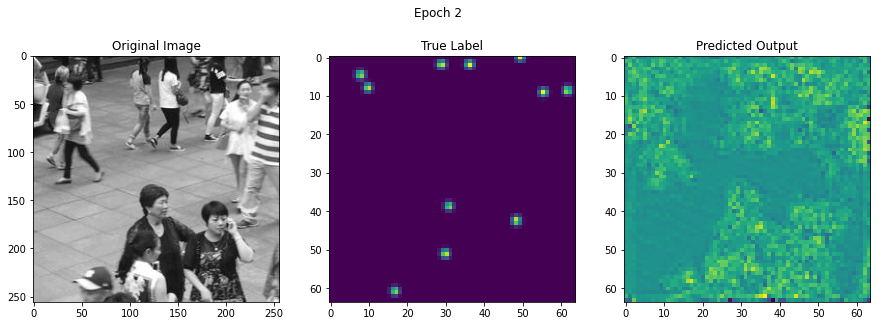

True Number:  tensor(10.7239, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(14.5077, device='cuda:0')


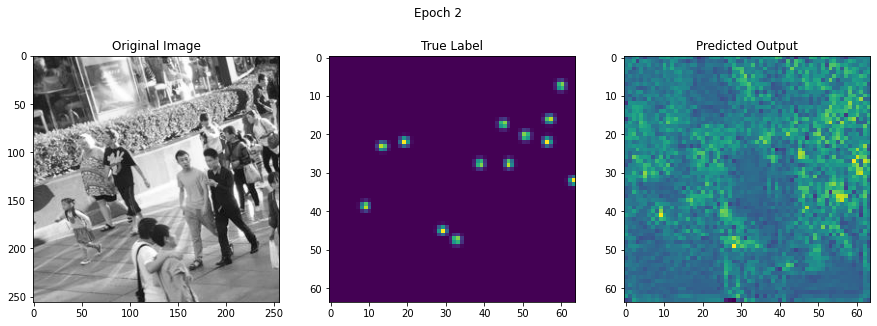

True Number:  tensor(12.8371, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(18.9136, device='cuda:0')


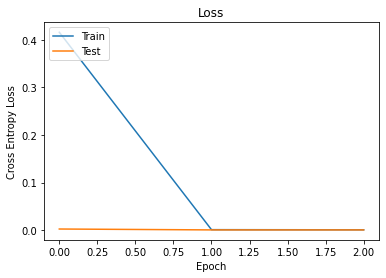

 Epoch 1,  Iteration  3001,  Loss: 0.0006128483
Sum Label:  tensor(1.0000, device='cuda:0', dtype=torch.float64) Sum Prediction:  tensor(12.4563, device='cuda:0', grad_fn=<SumBackward0>)


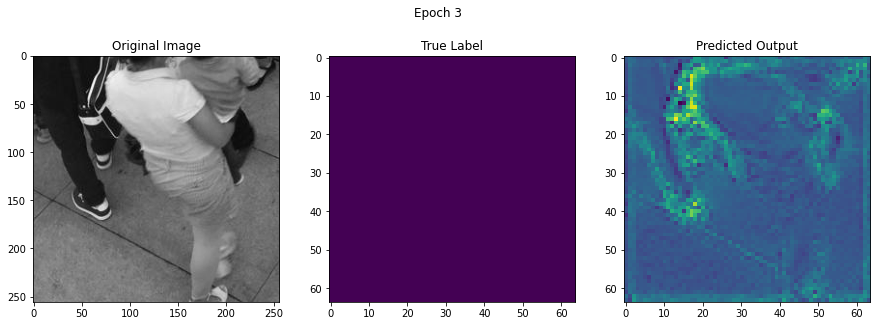

True Number:  tensor(0., device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(7.7840, device='cuda:0')


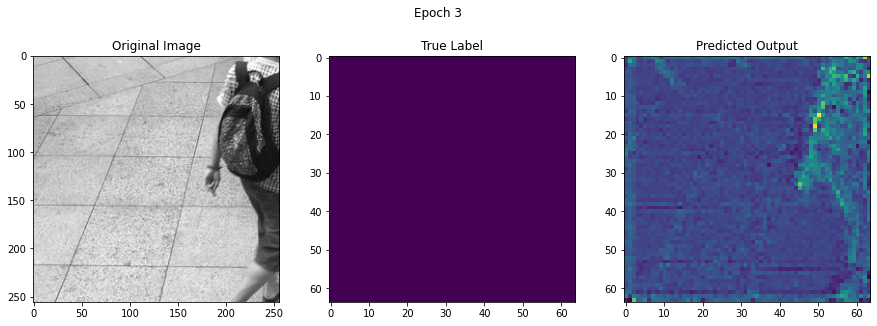

True Number:  tensor(0., device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(10.6397, device='cuda:0')


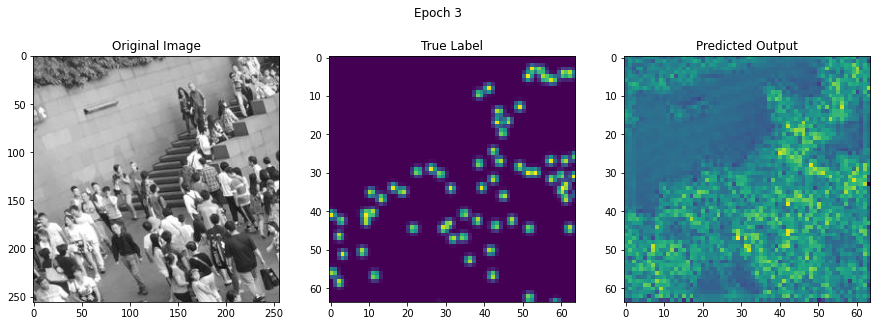

True Number:  tensor(65.3017, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(18.5027, device='cuda:0')


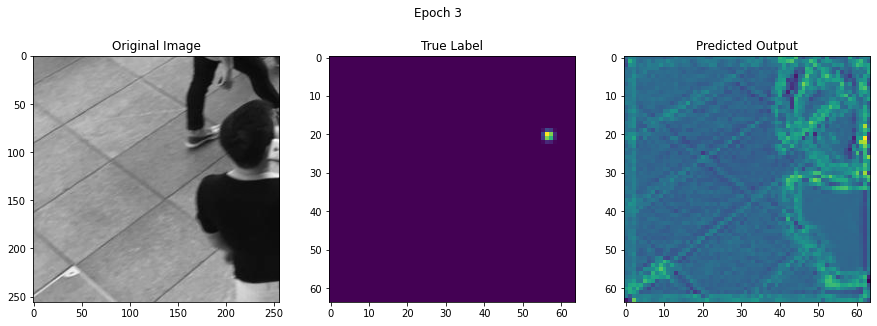

True Number:  tensor(1.0135, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(5.8783, device='cuda:0')


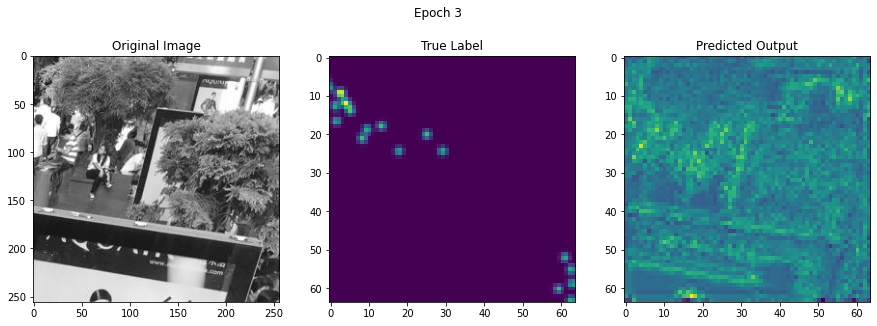

True Number:  tensor(18.0121, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(21.1510, device='cuda:0')


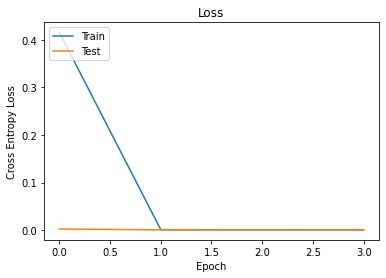

 Epoch 1,  Iteration  4001,  Loss: 0.0005692944
Sum Label:  tensor(2.0001, device='cuda:0', dtype=torch.float64) Sum Prediction:  tensor(12.3564, device='cuda:0', grad_fn=<SumBackward0>)


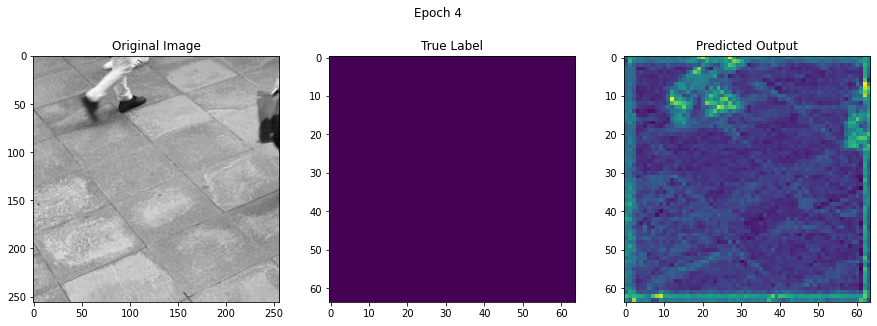

True Number:  tensor(0., device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(1.5981, device='cuda:0')


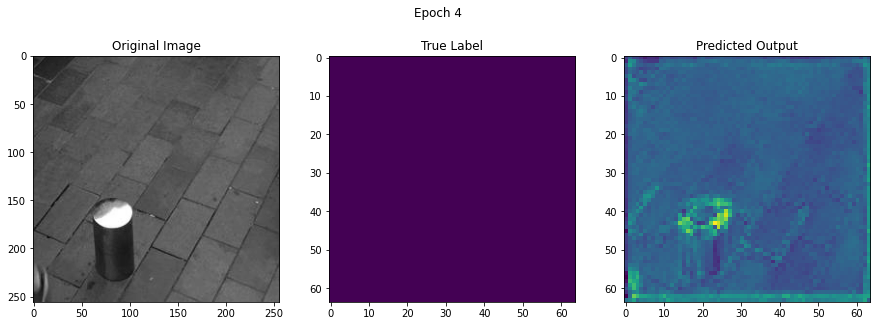

True Number:  tensor(0., device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(7.0486, device='cuda:0')


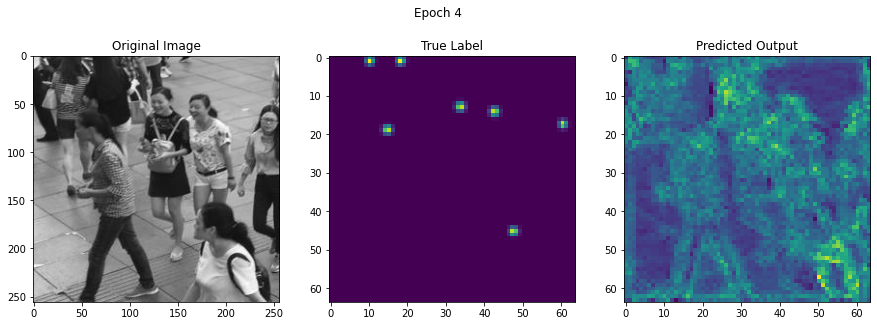

True Number:  tensor(6.9378, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(12.1504, device='cuda:0')


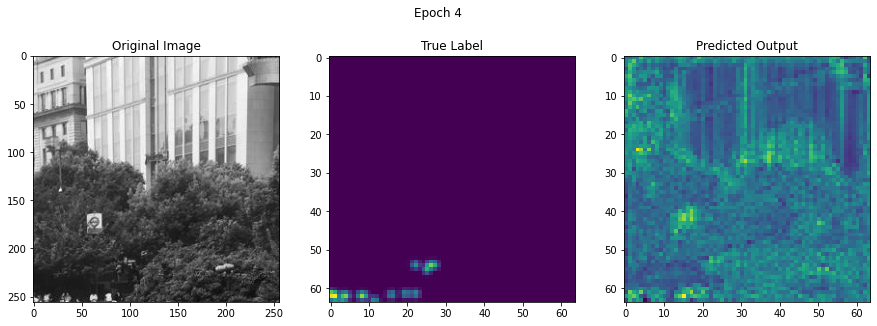

True Number:  tensor(14.7462, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(12.1862, device='cuda:0')


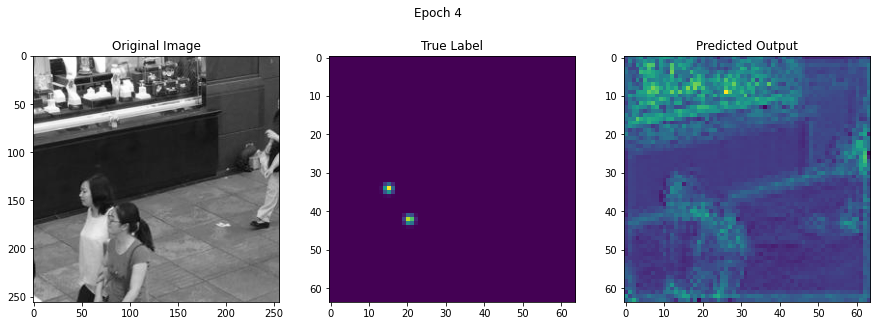

True Number:  tensor(1.9866, device='cuda:0', dtype=torch.float64) Predicted Number:  tensor(10.5676, device='cuda:0')


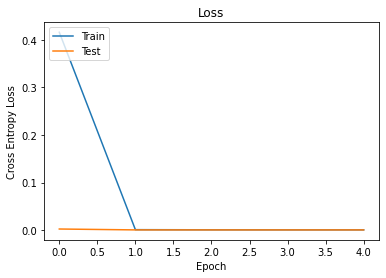

KeyboardInterrupt: ignored

In [ ]:
counter = 0
for epoch in range(60):  # loop over the dataset multiple times
  print("**********Epoch:",epoch+1,"**********")
  lossEpoch = 0.0
  cnt = 0
  running_loss = 0.0
  net = net.train()
  for img,gt_dmap in trainDataSHT:
    cnt = cnt +1
    if torch.cuda.is_available:
      img = Variable(img).cuda()
      gt_dmap =  Variable(gt_dmap).cuda()
    else:
      img = Variable(img)
      gt_dmap = Variable(gt_dmap)
    outputs = net(img.float())
    loss = criterion(outputs.view(-1,64,64), gt_dmap.view(-1,64,64).float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if cnt % 1000 == 1:    
        print(' Epoch %d,  Iteration %5d,  Loss: %.10f' %
              (epoch + 1, cnt, running_loss /(cnt)))
        print("Sum Label: ",torch.sum(gt_dmap), "Sum Prediction: ",torch.sum(outputs))
        #showResult(trainDataSHT, net, epoch)
        showResult(trainDataSHT, net, counter)
        lossValHist.append(calcLoss(valDataSHT, net, criterion))
        lossTrainHist.append(running_loss/cnt)
        #epochHist.append(epoch)
        epochHist.append(counter)
        plotLoss(epochHist, lossTrainHist, lossValHist)
        counter = counter +1
  print("Test Loss: ",  calcLoss(testDataSHT, net, criterion))

In [ ]:
shangTransform = shangTechTrans()
valData = shangTechDataset(transformer = shangTransform, dataDirs = valtDataDir, labelDirs = valLabelDir)
valDataSHT = DataLoader(valData, batch_size=BATCHSIZE, shuffle=True)

In [ ]:
print(np.shape(epochHist))
plotLoss(epochHist, lossTrainHist, lossValtHist)

In [ ]:
calcLoss(valDataSHT, net, criterion)

In [ ]:
epochHist, lossTrainHist, lossValtHist